In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from ipynb.fs.full.Performance_Utilities import calculate_optimal_threshold, print_metrics
from utils.create_features_utils import *
from sklearn.base import clone
import os

In [2]:
df = pd.read_csv('data/wimbledon_matches_with_feature.csv')
raw_tennis_file = "data/mens/combined_raw_data.csv"
round_16_file = "data/wimbledon_2019.csv"

In [3]:
round_16 = pd.read_csv(round_16_file) # Round of 16 and on from Wimbledon 2019
raw_tennis = pd.read_csv(raw_tennis_file) # Raw tennis file

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (27,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
features_list = [
 'diff_rank',
 'diff_match_win_percent',
 'diff_games_win_percent',
 'diff_5_set_match_win_percent',
 'diff_close_sets_percent',
 'diff_match_win_percent_grass',
 'diff_games_win_percent_grass',
 'diff_5_set_match_win_percent_grass',
 'diff_close_sets_percent_grass',
 'diff_match_win_percent_52',
 'diff_games_win_percent_52',
 'diff_5_set_match_win_percent_52',
 'diff_close_sets_percent_52',
 'diff_match_win_percent_grass_60',
 'diff_games_win_percent_grass_60',
 'diff_5_set_match_win_percent_grass_60',
 'diff_close_sets_percent_grass_60',
 'diff_match_win_percent_hh',
 'diff_games_win_percent_hh',
 'diff_match_win_percent_grass_hh',
 'diff_games_win_percent_grass_hh']

In [5]:
df = df.dropna()

df['diff_rank'] = df['player_0_rank'] - df['player_1_rank']

In [6]:
# Train-test split
y = df.outcome
X = df[features_list]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, shuffle=True, test_size=0.20)

In [7]:
# Final to predict on
round_16['Date'] = '2019/07/07'
round_16['Surface'] = 'Grass'
round_16['diff_rank'] = round_16['player_0_rank'] - round_16['player_1_rank']

wimby_2019 = create_features(round_16, raw_tennis) # Round 16 and on Wimby 2019
X_wimby_2019 = wimby_2019[features_list]

Creating Player Career Stats All Surface
Creating Player Career Stats on Grass/Clay/Hard
Creating Player Career Stats All Surface Last 52 Weeks
Creating Player Career Stats on Grass/Clay/Hard Last 60 Weeks
Creating Player Head to Head Career Stats All Surface
Creating Player Head to Head Career Stats On Grass
Creating Difference Variables


In [8]:
wimby_2019.columns

Index(['Round', 'player_0', 'player_0_rank', 'player_1', 'player_1_rank',
       'Date', 'Surface', 'diff_rank', 'player_0_match_win_percent',
       'player_1_match_win_percent', 'player_0_games_win_percent',
       'player_1_games_win_percent', 'player_0_5_set_match_win_percent',
       'player_1_5_set_match_win_percent', 'player_0_close_sets_percent',
       'player_1_close_sets_percent', 'player_0_match_win_percent_grass',
       'player_1_match_win_percent_grass', 'player_0_games_win_percent_grass',
       'player_1_games_win_percent_grass',
       'player_0_5_set_match_win_percent_grass',
       'player_1_5_set_match_win_percent_grass',
       'player_0_close_sets_percent_grass',
       'player_1_close_sets_percent_grass', 'player_0_match_win_percent_52',
       'player_1_match_win_percent_52', 'player_0_games_win_percent_52',
       'player_1_games_win_percent_52', 'player_0_5_set_match_win_percent_52',
       'player_1_5_set_match_win_percent_52', 'player_0_close_sets_percent_5

In [9]:
# Random Forest
rfc = RandomForestClassifier(n_estimators=1100, max_depth = 3, random_state=19, n_jobs=-1)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1100,
                       n_jobs=-1, oob_score=False, random_state=19, verbose=0,
                       warm_start=False)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1143: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


,Model,Accuracy,True Positive Rate,True Negative Rate,False Positive Rate,False Negative Rate,Sensitivity,Specificity,AUC,F1-Score,Geometric Mean,Kappa-Statistics,Sklearn Version
0,RF,0.718,0.23,0.906,0.094,0.77,0.23,0.906,0.698,0.311,0.456,0.161,0.22


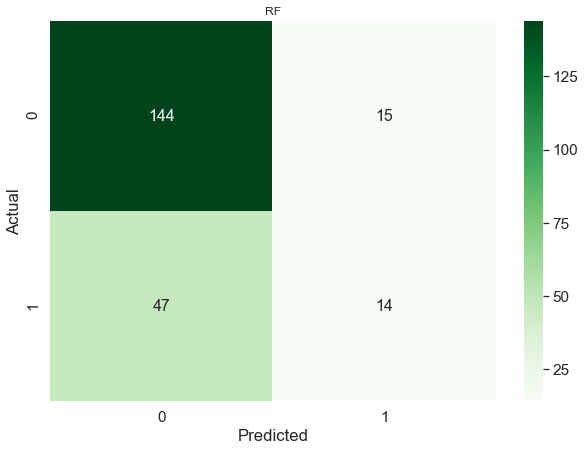

In [10]:
print_metrics(X_test, y_test, rfc, "RF")[1]

In [11]:
rfc.predict_proba(X_wimby_2019)

array([[0.87954493, 0.12045507],
       [0.54744832, 0.45255168],
       [0.84772091, 0.15227909],
       [0.84412997, 0.15587003],
       [0.83665707, 0.16334293],
       [0.88667315, 0.11332685],
       [0.86329678, 0.13670322],
       [0.86565804, 0.13434196],
       [0.87049969, 0.12950031],
       [0.52647674, 0.47352326],
       [0.8661331 , 0.1338669 ],
       [0.83927852, 0.16072148],
       [0.83655792, 0.16344208],
       [0.50126461, 0.49873539],
       [0.52440783, 0.47559217],
       [0.57504192, 0.42495808]])

In [16]:
# xgb_model.predict_proba(X_wimby_2019)

array([[0.99429965, 0.00570033],
       [0.65820616, 0.34179384],
       [0.9796694 , 0.02033064],
       [0.8728488 , 0.12715118],
       [0.9407589 , 0.05924113],
       [0.99283147, 0.00716855],
       [0.97538215, 0.02461786],
       [0.9287607 , 0.07123927],
       [0.9127725 , 0.08722753],
       [0.46480143, 0.53519857],
       [0.9842351 , 0.01576491],
       [0.91493887, 0.08506115],
       [0.8477629 , 0.15223713],
       [0.47899574, 0.52100426],
       [0.6658686 , 0.33413142],
       [0.443228  , 0.556772  ]], dtype=float32)